In [1]:
from scipy.misc import comb
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) * error**k * (1- error) ** (n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier=11, error=0.25)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  """


0.03432750701904297

In [2]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label='Ensemble error', lw=2)
plt.plot(error_range, error_range, label='Base error', ls='--', lw=2)
plt.xlabel('Base error')
plt.ylabel('Base / Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  """


<Figure size 640x480 with 1 Axes>

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers) }
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
            
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
clf1 = LogisticRegression(penalty='l2',
                         C=0.001,
                         random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, 
                             criterion='entropy',
                             random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                           p=2,
                           metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation: ¥n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, 
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print('ROC AUC: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))

10-fold cross validation: ¥n
ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


In [7]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train, 
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print('ROC AUC: %.3f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))

ROC AUC: 0.872 (+/- 0.17) [Logistic regression]
ROC AUC: 0.892 (+/- 0.16) [Decision tree]
ROC AUC: 0.883 (+/- 0.15) [KNN]
ROC AUC: 0.944 (+/- 0.13) [Majority voting]


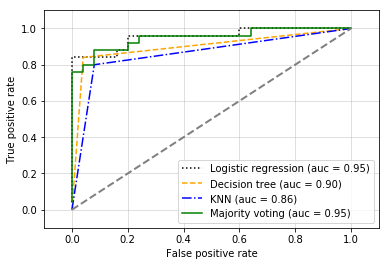

In [8]:
from sklearn.metrics import roc_curve, auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=clr, ls=ls, label='%s (auc = %.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],ls='--',color='gray', lw=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


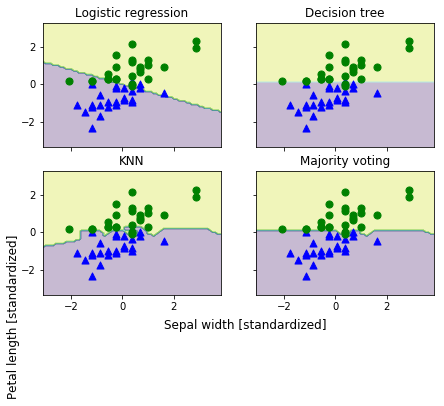

In [12]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
y_min = X_train_std[:, 1].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), 
                    np.arange(y_min, y_max, 0.1) )

f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))

for idx, clf, tt in zip(product([0,1],[0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^',s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='green', marker='o',s=50)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-12.5, -4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [13]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=No

In [14]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.01, 0.1, 100]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.01, 0.1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [16]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print('%.3f +/- %.2f %r' % (grid.cv_results_['mean_test_score'][r], grid.cv_results_['std_test_score'][r], grid.cv_results_['params'][r]))

0.947 +/- 0.14 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.01}
0.947 +/- 0.14 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
0.947 +/- 0.14 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.01}
0.947 +/- 0.14 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100}


In [19]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                  'Alcalinity of ash', 'Mangesium', 'Total phenols', 'Flavanoids', 
                  'Nonflavanoid', 'Proanthocyanins', 'Color intensity', 'Hue', 
                  'OD28/OD315 of diluted wines', 'Prolines']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD28/OD315 of diluted wines']].values

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [23]:
y_test

array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0])

In [24]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500,
                        max_samples=1.0, max_features=1.0, 
                        bootstrap=True, bootstrap_features=False,
                       n_jobs=1,
                       random_state=1)


In [28]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [29]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.917


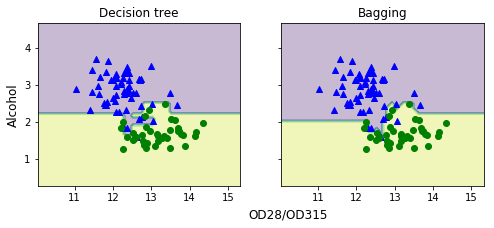

In [30]:
x_min = X_train[:, 0].min() -1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() -1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))
for idx, clf, tt in zip([0,1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol',  fontsize=12)
plt.text(10.2, -0.5, s='OD28/OD315', ha='center',va='center', fontsize=12)
plt.show()

In [32]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth=1,
                             random_state=1)
ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracy %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracy 0.916/0.875


In [33]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.917


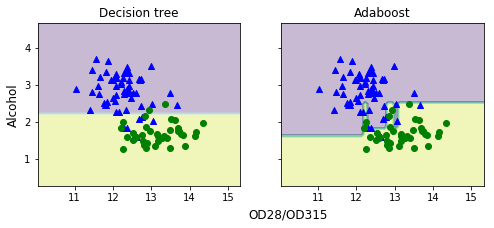

In [34]:
x_min = X_train[:, 0].min() -1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() -1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))
for idx, clf, tt in zip([0,1], [tree, ada], ['Decision tree', 'Adaboost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol',  fontsize=12)
plt.text(10.2, -0.5, s='OD28/OD315', ha='center',va='center', fontsize=12)
plt.show()